In [1]:
import numpy as np
from scipy.optimize import minimize
from statsmodels.tools.numdiff import approx_fprime, approx_hess
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
def transform(params, restrictions):
    params_trans = np.zeros(params.shape)
    for i in range(len(params)):
        if restrictions[i] == 'pos':
            params_trans[i] = np.log(params[i])
        elif restrictions[i] == '01':
            params_trans[i] = np.log(params[i]) - np.log(1 - params[i])
        else:
            params_trans[i] = params[i]
    return params_trans

def transform_back(params_trans, restrictions):
    params = np.zeros(params_trans.shape)
    for i in range(len(params_trans)):
        if restrictions[i] == 'pos':
            params[i] = np.exp(params_trans[i])
        elif restrictions[i] == '01':
            params[i] = 1 / (1 + np.exp(-params_trans[i]))
        else:
            params[i] = params_trans[i]
    return params

def gradient(param_trans, restrictions):
    g = np.zeros_like(param_trans)
    for i in range(len(g)):
        if restrictions[i] == '':
            g[i] = 1
        elif restrictions[i] == 'pos':
            g[i] = np.exp(param_trans[i])
        else:
            g[i] = np.exp(param_trans[i]) / np.power(1 + np.exp(param_trans[i]), 2)
    return g

In [3]:
def garch_filter(params, returns):
    un_var = params[1]/(1 - params[2] - params[3])
    sigma2 = np.zeros_like(returns)
    
    for i in range(len(returns)):
        if i == 0:
            sigma2[i] = un_var
        else:
            sigma2[i] = np.dot(un_var, (1 - params[2] - params[3])) + np.dot((1 - params[3] - params[1] / un_var), (returns[i-1] - params[0]) ** 2) + np.dot((1 - params[2] - params[1] / un_var), sigma2[i - 1])
    return sigma2

def normal_loglikelihood(params, returns):
    sigma2 = garch_filter(params, returns)
    lls = 0.5 * (np.log(2*np.pi) + np.log(sigma2) + (returns - params[0])**2 / sigma2)
    return sum(lls)/len(returns)

def normal_loglikelihood_trans(params_trans, returns, restrictions):
    params = transform_back(params_trans, restrictions)
    return normal_loglikelihood(params, returns)

In [4]:
np.random.seed(14)
returns = np.random.normal(0, 1, 1000)

In [5]:
init_params = np.array([0.05, 0.1, 0.02, 0.95])
restrictions = np.array(['', '01', '01', '01'])
init_params_trans = transform(init_params, restrictions)

In [6]:
opt = minimize(normal_loglikelihood_trans, 
               init_params_trans,
               args = (np.asarray(returns), restrictions),
               method = "l-bfgs-b",
               options = {'disp': None, 'maxiter': 250}
              )

In [7]:
params = transform_back(opt.x, restrictions)
hess = approx_hess(params, normal_loglikelihood, kwargs = {'returns': returns})
#hess /= returns.shape[0] <- ez nem kell, mert már osztottam a megfigyelések számával a loglikelihood-ot
inv_hess = np.linalg.inv(hess)
se = np.diag(inv_hess / returns.shape[0])
upper = params + 1.96 * se
lower = params - 1.96 * se

In [8]:
table = pd.DataFrame(data = {'Parameters': params, 'Standard Error': se, '95% CI lower': lower, '95% CI upper': upper, 't value': params/se, 'p-value': stats.norm.sf(np.abs(params/se)) * 2})
print('Log-likelihood: ', opt.fun*len(returns))
display(table)

Log-likelihood:  1442.7246895070516


,Parameters,Standard Error,95% CI lower,95% CI upper,t value,p-value
0,-0.087806,0.001050,-0.089864,-0.085747,-83.609049,0.000000e+00
1,0.144326,0.091729,-0.035463,0.324114,1.573395,1.156274e-01
2,0.003480,0.000291,0.002910,0.004050,11.970425,5.076790e-33
3,0.858901,0.086509,0.689343,1.028459,9.928428,3.131520e-23


In [9]:
gradient = gradient(opt.x, restrictions)
variance = opt.hess_inv.todense() / len(returns)
high = params + 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), gradient)
low = params - 1.96 * np.multiply(np.sqrt(np.diagonal(variance)), gradient)

table2 = pd.DataFrame(data = {'Parameters': params, 'Standard Error': np.multiply(np.sqrt(np.diagonal(variance)), gradient), '95% CI lower': low, '95% CI upper': high, 't value': params/np.multiply(np.sqrt(np.diagonal(variance)), gradient), 'p-value': stats.norm.sf(np.abs(params/np.multiply(np.sqrt(np.diagonal(variance)), gradient))) * 2})
print('Standard Error estimation:')
display(table2)

Standard Error estimation:


,Parameters,Standard Error,95% CI lower,95% CI upper,t value,p-value
0,-0.087806,0.031872,-0.150274,-0.025337,-2.754958,5.869971e-03
1,0.144326,0.147628,-0.145024,0.433676,0.977634,3.282555e-01
2,0.003480,0.009050,-0.014257,0.021218,0.384577,7.005506e-01
3,0.858901,0.130031,0.604040,1.113762,6.605356,3.965625e-11


In [10]:
from arch import arch_model

am = arch_model(returns)
res  = am.fit(update_freq = 5)
print(res)

Iteration:      5,   Func. Count:     36,   Neg. LLF: 1460.90711335737
Iteration:     10,   Func. Count:     66,   Neg. LLF: 1444.6811804621777
Iteration:     15,   Func. Count:     98,   Neg. LLF: 1442.6462889827285
Iteration:     20,   Func. Count:    124,   Neg. LLF: 1442.6251561669797
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1442.6251319982616
            Iterations: 23
            Function evaluations: 138
            Gradient evaluations: 23
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1442.63
Distribution:                  Normal   AIC:                           2893.25
Method:            Maximum Likelihood   BIC:                           2912.88
                         

In [11]:
def garch_sim(params, num):
    alpha0 = params[0]
    alpha1 = params[1]
    beta1 = params[2]
    
    alpha = alpha0/(1 - alpha1 - beta1)
    
    sigma2 = []
    returns = np.random.normal(0, 1, size = num)
    
    for i in range(num):
        if i == 0:
            sigma2.append(alpha)
        else:
            sigma2.append((alpha0 + alpha1 * sigma2[i-1] + beta1 * returns[i-1]**2 * np.sqrt(sigma2[i - 1])))
            
    return sigma2, returns

In [12]:
np.random.seed(2021)

sigma2, returns = garch_sim([0.2, 0.2, 0.6], 250)
S = 100*np.exp(np.cumsum(returns))

Text(0.5, 1.0, 'Returns')

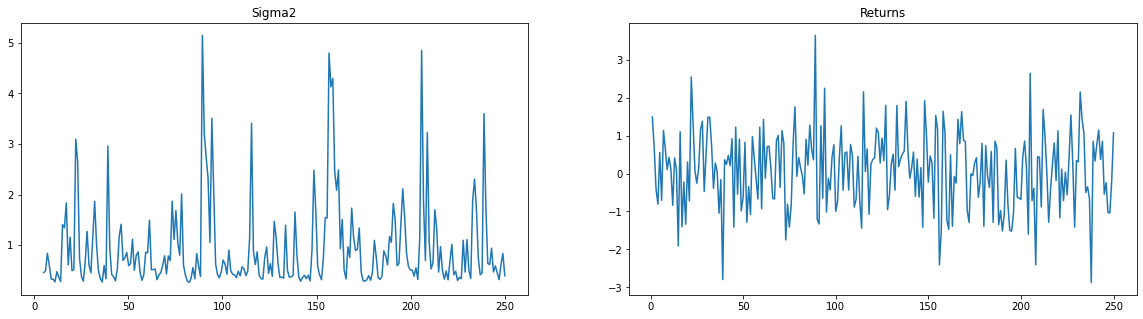

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 5, forward=True)
ax1.plot(np.linspace(5,250,245), sigma2[5:])
ax1.set_title('Sigma2')
ax2.plot(np.linspace(1,250,250), returns)
ax2.set_title('Returns')